In [1]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Initialize Firebase
cred = credentials.Certificate("city-sentry-firebase.json")  # Use your downloaded JSON key
firebase_admin.initialize_app(cred)

# Connect to Firestore
db = firestore.client()

# Retrieve the collection
collection_name = "reports"
docs = db.collection(collection_name).stream()

# Convert to DataFrame
data = []
for doc in docs:
    doc_dict = doc.to_dict()
    doc_dict["id"] = doc.id  # Optionally store Firestore document ID
    data.append(doc_dict)

df = pd.DataFrame(data)
df.to_csv("data/reports.csv", index=False)

In [2]:
# Define tag groups and colors
tag_groups = {
    'environmental': ['Litter', 'Illegal Dumping', 'Air Pollution', 'Water Pollution'],
    'infrastructure': ['Pothole', 'Cracked Pavement', 'Broken Streetlight', 'Damaged Bench', 'Blocked Drainage', 'Abandoned Vehicle'],
    'safety': ['Vandalism', 'Unsafe Building', 'Unsafe Bridge', 'Broken Traffic Signals', 'Open Manholes'],
    'aesthetic': ['Overgrown Vegetation', 'Graffiti', 'Neglected Monuments', 'Faded Paint'],
    'wildlife': ['Dead Animals', 'Animal Menace']
}

group_colors = {
    'environmental': 'green',
    'infrastructure': 'blue',
    'safety': 'red',
    'aesthetic': 'yellow',
    'wildlife': 'purple',
}

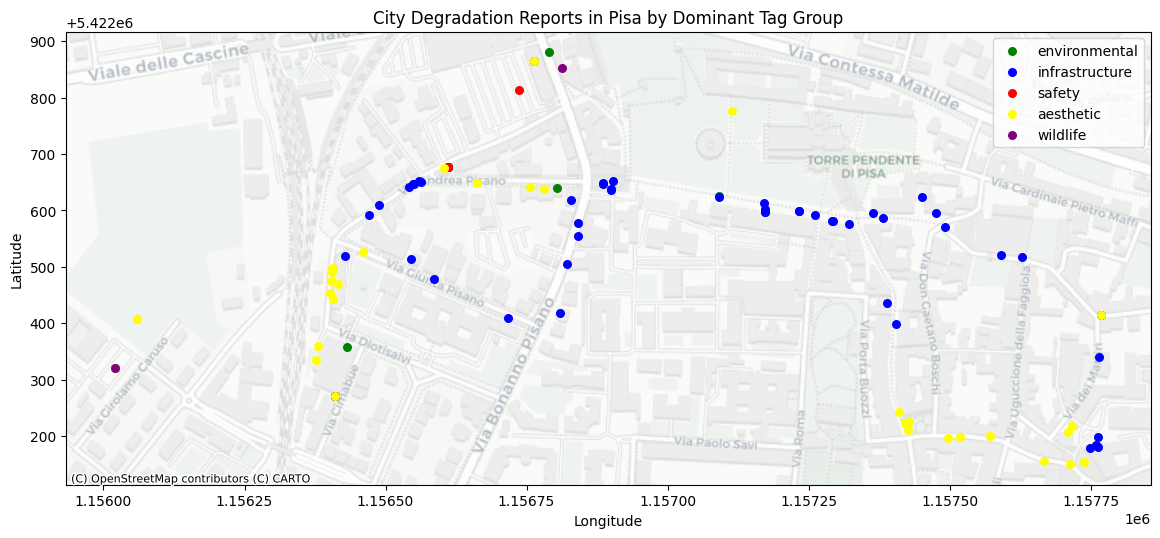

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import ast

# Load data from CSV
df = pd.read_csv('data/reports.csv')

# Ensure 'location' and 'tags' columns are properly formatted
df['location'] = df['location'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filter only reports within Pisa's geographic boundaries
df_pisa = df.loc[
    (df['location'].apply(lambda x: x['latitude']).between(43.65, 43.75)) &
    (df['location'].apply(lambda x: x['longitude']).between(10.35, 10.50))
].copy()

# Convert to GeoDataFrame
geometry = [Point(loc['longitude'], loc['latitude']) for loc in df_pisa['location']]
gdf_pisa = gpd.GeoDataFrame(df_pisa, geometry=geometry, crs="EPSG:4326")
gdf_pisa = gdf_pisa.to_crs(epsg=3857)

# Function to determine the dominant group for each report
def get_dominant_group(tags):
    group_counts = {group: sum(1 for tag in tags if tag in tags_list) for group, tags_list in tag_groups.items()}
    return max(group_counts, key=group_counts.get)

# Assign dominant group and color, handling missing groups
gdf_pisa['dominant_group'] = gdf_pisa['tags'].apply(lambda x: get_dominant_group(x) if isinstance(x, list) else None)
gdf_pisa['color'] = gdf_pisa['dominant_group'].map(group_colors)

# Plot with colors based on dominant group
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

for group, color in group_colors.items():
    subset = gdf_pisa[gdf_pisa['dominant_group'] == group]
    subset.plot(ax=ax, color=color, markersize=30, alpha=1, label=group)

ctx.add_basemap(ax, crs=gdf_pisa.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_title('City Degradation Reports in Pisa by Dominant Tag Group')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()
plt.show()

In [4]:
# sistemare in modo sus i timestamp

In [8]:
import pandas as pd
from sklearn.cluster import DBSCAN
from datetime import timedelta
import numpy as np

# Convert 'timestamp' column to datetime format
df_pisa['timestamp'] = pd.to_datetime(df_pisa['timestamp'], format='ISO8601')

# DBSCAN parameters
eps = 0.002
min_samples = 2

# Function to apply DBSCAN on a sliding window
def cluster_reports_by_group(data, group_name, tags, window_size=30, slide=5):
    results = []
    start_date = data['timestamp'].min()
    end_date = data['timestamp'].max()

    while start_date + timedelta(minutes=window_size) <= end_date:
        # Filter data for the current window and tag group
        window_end = start_date + timedelta(minutes=window_size)
        window_data = data[(data['timestamp'] >= start_date) & (data['timestamp'] < window_end)]
        window_data = window_data[window_data['tags'].apply(lambda x: any(tag in tags for tag in x))]
        # Extract latitude and longitude for clustering
        if not window_data.empty:
            coords = np.array([[loc['latitude'], loc['longitude']] for loc in window_data['location']])
            
            # Apply DBSCAN
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
            window_data['cluster'] = db.labels_
            
            # Calculate cluster properties
            for cluster_id in set(db.labels_):
                if cluster_id != -1:  # Ignore noise
                    cluster_points = window_data[window_data['cluster'] == cluster_id]
                    centroid_lat = cluster_points['location'].apply(lambda loc: loc['latitude']).mean()
                    centroid_lon = cluster_points['location'].apply(lambda loc: loc['longitude']).mean()
                    centroid = (centroid_lat, centroid_lon)
                    results.append({
                        'group': group_name,
                        'start_date': start_date,
                        #'end_date': window_end,
                        #'cluster_id': cluster_id,
                        'centroid': centroid,
                        'volume': len(cluster_points),
                        #'report_ids': cluster_points['id'].tolist()
                    })

        # Slide the window
        start_date += timedelta(minutes=slide)
    
    return results

# Apply clustering for each tag group
all_results = []
for group_name, tags in tag_groups.items():
    group_results = cluster_reports_by_group(df_pisa, group_name, tags)
    all_results.extend(group_results)

# Convert results to a dataframe for easier analysis
clusters_df = pd.DataFrame(all_results)
clusters_df.to_csv("data/clusters.csv", index=False)


In [9]:
# Salvare i risultati su Firestore 

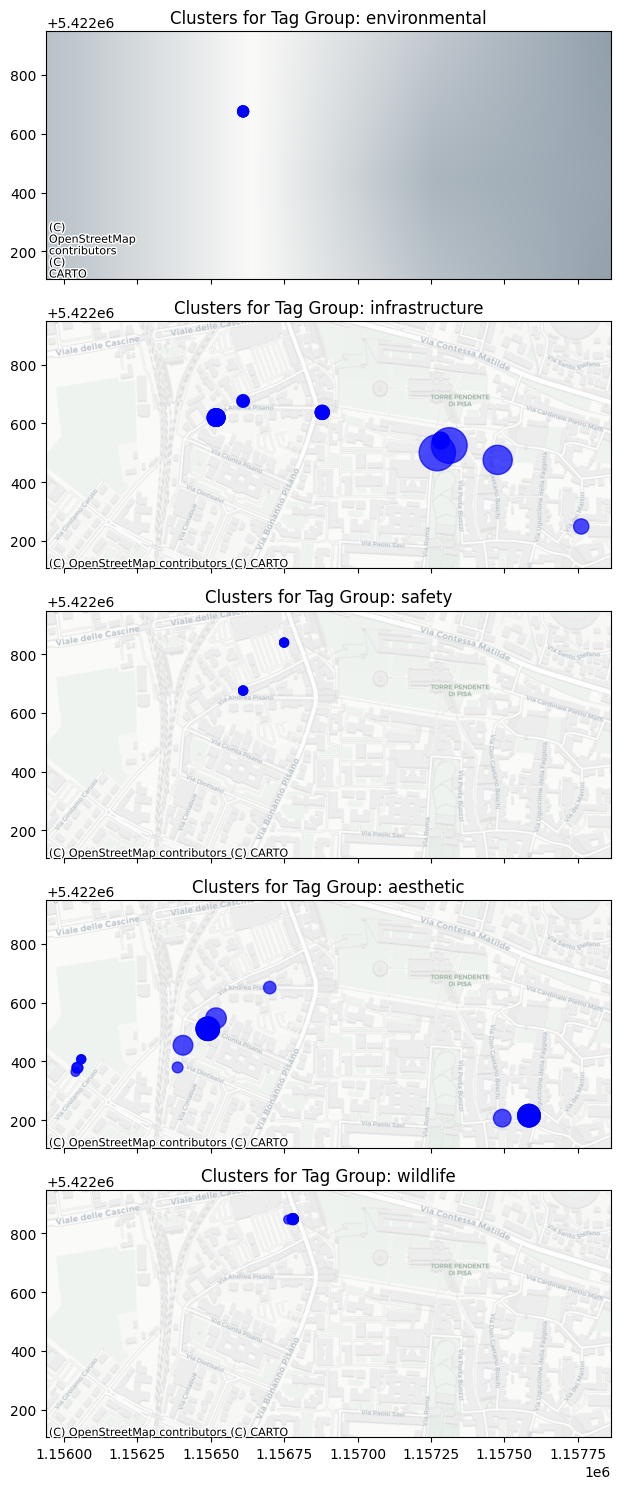

In [10]:
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point

# Convert the centroid column to a GeoSeries
clusters_df['geometry'] = clusters_df['centroid'].apply(lambda x: Point(x[1], x[0]))  # Longitude first for Point
gdf = gpd.GeoDataFrame(clusters_df, geometry='geometry', crs="EPSG:4326")

# Reproject to Web Mercator (the coordinate system required by contextily)
gdf = gdf.to_crs(epsg=3857)
min_x, min_y, max_x, max_y = gdf.total_bounds 
# Plot the clusters on a basemap
subsets = {}
for i, tag_group in enumerate(tag_groups):
    subset = gdf[gdf['group'] == tag_group]
    if len(subset) == 0:
        continue
    subsets[tag_group] = subset

fig, ax = plt.subplots(len(subsets), 1, figsize=(8, 15), sharex=True, sharey=True)

for i, (tag_group, subset) in enumerate(subsets.items()):
    subset.plot(ax=ax[i], color='blue', markersize=subset['volume'] * 20, alpha=0.7, legend=True)
    ctx.add_basemap(ax[i], source=ctx.providers.CartoDB.Positron)

    ax[i].set_xlim(min_x-100, max_x+100)
    ax[i].set_ylim(min_y-100, max_y+100)
    ax[i].set_title(f'Clusters for Tag Group: {tag_group}')

plt.tight_layout()
plt.show()

